# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [ ]:
import gym
import random
import torch
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [ ]:
env = gym.make('CartPole-v0').unwrapped
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (4,)
Number of actions:  2


Before running the next code cell, familiarize yourself with the code in **Step 2** and **Step 3** of this notebook, along with the code in `dqn_agent.py` and `model.py`.  Once you have an understanding of how the different files work together, 
- Define a neural network architecture in `model.py` that maps states to action values.  This file is mostly empty - it's up to you to define your own deep Q-network!
- Finish the `learn` method in the `Agent` class in `dqn_agent.py`.  The sampled batch of experience tuples is already provided for you; you need only use the local and target Q-networks to compute the loss, before taking a step towards minimizing the loss.

Once you have completed the code in `dqn_agent.py` and `model.py`, run the code cell below.  (_If you end up needing to make multiple changes and get unexpected behavior, please restart the kernel and run the cells from the beginning of the notebook!_)

You can find the solution files, along with saved model weights for a trained agent, in the `solution/` folder.  (_Note that there are many ways to solve this exercise, and the "solution" is just one way of approaching the problem, to yield a trained agent._)

In [ ]:
import math

class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """

    def __init__(self, in_features: int, out_features: int, std_init: float = 0.5):
        """Initialization."""
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.FloatTensor(np.random.normal(loc=0.0, scale=1.0, size=size))

        return x.sign().mul(x.abs().sqrt())

In [ ]:
class QNetwork(nn.Module):
  """Actor (Policy) Model."""
  def __init__(self, state_size, action_size, seed, fc1_unit=64, fc2_unit=64):
    """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
    """
    super(QNetwork, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, fc1_unit)
    self.fc2 = nn.Linear(fc1_unit, fc2_unit)
    self.fc3 = nn.Linear(fc2_unit, action_size)

  def forward(self, state):
    """Build a network that maps state -> action values."""
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    return self.fc3(x)
      

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, seed):
        """Initialization."""
        super(QNetwork, self).__init__()

        self.feature = nn.Linear(in_dim, 64)
        self.noisy_layer1 = NoisyLinear(64, 64)
        self.noisy_layer2 = NoisyLinear(64, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        feature = F.relu(self.feature(x))
        hidden = F.relu(self.noisy_layer1(feature))
        out = self.noisy_layer2(hidden)
        
        return out
    
    def reset_noise(self):
        """Reset all noisy layers."""
        self.noisy_layer1.reset_noise()
        self.noisy_layer2.reset_noise()

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [ ]:
class Agent():
  """Interacts with and learns from the environment."""

  def __init__(self, state_size, action_size, seed):
    """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
    """
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    #Q-Networks
    self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
    self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

    #Replay memory
    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    # Save experience in replay memory
    self.memory.add(state, action, reward, next_state, done)
    # Learn every UPDATE_EVERY time steps.
    self.t_step = (self.t_step + 1) % UPDATE_EVERY
    if self.t_step == 0:
       # If enough samples are available in memory, get random subset and learn
      if len(self.memory) > BATCH_SIZE:
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)

  def act(self, state, eps = 0):
    """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
      action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    return np.argmax(action_values.cpu().data.numpy())




  def learn(self, experiences, gamma):
    states, actions, reward, next_states, dones = experiences
    # Get max predicted Q values (for next states) from target model
    Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
    
    # Compute Q targets for current states
    Q_targets = reward + (gamma * Q_targets_next * (1 - dones))
    # Get expected Q values from local model
    Q_expected = self.qnetwork_local(states).gather(1, actions)
    #Compute loss 
    loss = F.mse_loss(Q_expected, Q_targets)
    #Minimize loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.qnetwork_local.reset_noise()
    self.qnetwork_target.reset_noise()

    # ------------------- update target network ------------------- #
    self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)     
  
  def soft_update(self, local_model, target_model, tau):
    """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
class ReplayBuffer:
  def __init__(self, action_size, buffer_size, batch_size, seed):
    """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
    """
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size)  
    self.batch_size = batch_size
    self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    self.seed = random.seed(seed)


  def add(self, state, action, reward, next_state, done):
    """Add a new experience to memory."""

    e = self.experience(state, action, reward, next_state, done)
    self.memory.append(e)

  def sample(self):

    experiences = random.sample(self.memory, k=self.batch_size)
    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

    return (states, actions, reward, next_states, dones)

  def __len__(self):
    """Return the current size of internal memory."""
    return len(self.memory)



In [ ]:
agent = Agent(state_size=4, action_size=2, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Episode 100	Average Score: 15.14
Episode 200	Average Score: 15.13
Episode 300	Average Score: 14.06
Episode 400	Average Score: 13.79
Episode 500	Average Score: 14.61
Episode 600	Average Score: 12.50
Episode 700	Average Score: 11.75
Episode 800	Average Score: 13.70
Episode 900	Average Score: 15.01
Episode 1000	Average Score: 18.20
Episode 1100	Average Score: 25.05
Episode 1200	Average Score: 37.10
Episode 1300	Average Score: 182.78
Episode 1310	Average Score: 200.89
Environment solved in 1210 episodes!	Average Score: 200.89


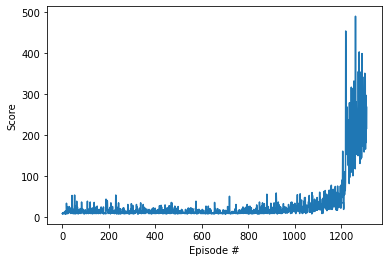

In [ ]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
  """Deep Q-Learning.
  
  Params
  ======
      n_episodes (int): maximum number of training episodes
      max_t (int): maximum number of timesteps per episode
      eps_start (float): starting value of epsilon, for epsilon-greedy action selection
      eps_end (float): minimum value of epsilon
      eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
  """
  scores = []
  scores_window = deque(maxlen = 100)
  eps = eps_start

  for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for t in range(max_t):
      action = agent.act(state, eps)
      next_state, reward, done, _ = env.step(action)
      agent.step(state, action, reward, next_state, done)
      state = next_state
      score += reward
      if done :
        break

    scores_window.append(score)
    scores.append(score)
    eps = max(eps_end, eps_decay * eps)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=200.0:
      print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
      torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
      break
  return scores


scores = dqn()



# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        #env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  

In [ ]:
class DDQNAgent():
  """Interacts with and learns from the environment."""

  def __init__(self, state_size, action_size, seed):
    """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
    """
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    #Q-Networks
    self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
    self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

    #Replay memory
    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    # Save experience in replay memory
    self.memory.add(state, action, reward, next_state, done)
    # Learn every UPDATE_EVERY time steps.
    self.t_step = (self.t_step + 1) % UPDATE_EVERY
    if self.t_step == 0:
       # If enough samples are available in memory, get random subset and learn
      if len(self.memory) > BATCH_SIZE:
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)

  def act(self, state, eps = 0):
    """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
      action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    if random.random() > eps:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))


  def learn(self, experiences, gamma):
    states, actions, reward, next_states, dones = experiences
    # Get max predicted Q values (for next states) from target model
    Q_targets_next = self.qnetwork_target(next_states).gather(1,self.qnetwork_local(next_states).argmax(1, keepdim=True)).detach()
    # Compute Q targets for current states
    Q_targets = reward + (gamma * Q_targets_next * (1 - dones))
    # Get expected Q values from local model
    Q_expected = self.qnetwork_local(states).gather(1, actions)
    #Compute loss 
    loss = F.mse_loss(Q_expected, Q_targets)
    #Minimize loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # ------------------- update target network ------------------- #
    self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)     
  
  def soft_update(self, local_model, target_model, tau):
    """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
agent = DDQNAgent(state_size=4, action_size=2, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

Episode 100	Average Score: 17.28
Episode 200	Average Score: 12.52
Episode 300	Average Score: 11.09
Episode 400	Average Score: 10.42
Episode 500	Average Score: 10.03
Episode 600	Average Score: 9.64
Episode 700	Average Score: 9.58
Episode 800	Average Score: 9.94
Episode 900	Average Score: 12.33
Episode 1000	Average Score: 59.08
Episode 1100	Average Score: 187.51
Episode 1139	Average Score: 200.33
Environment solved in 1039 episodes!	Average Score: 200.33


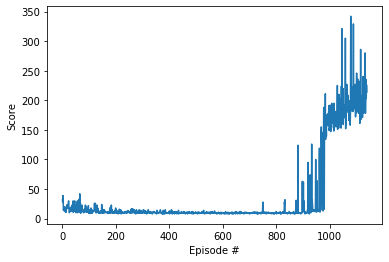

In [ ]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
  """Deep Q-Learning.
  
  Params
  ======
      n_episodes (int): maximum number of training episodes
      max_t (int): maximum number of timesteps per episode
      eps_start (float): starting value of epsilon, for epsilon-greedy action selection
      eps_end (float): minimum value of epsilon
      eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
  """
  scores = []
  scores_window = deque(maxlen = 100)
  eps = eps_start

  for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for t in range(max_t):
      action = agent.act(state, eps)
      next_state, reward, done, _ = env.step(action)
      agent.step(state, action, reward, next_state, done)
      state = next_state
      score += reward
      if done :
        break

    scores_window.append(score)
    scores.append(score)
    eps = max(eps_end, eps_decay * eps)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=200.0:
      print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
      torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
      break
  return scores


scores = dqn()



# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
class QNetwork(nn.Module):
  """Actor (Policy) Model."""
  def __init__(self, state_size, action_size, seed, fc1_unit=64, fc2_unit=64):
    """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
    """
    super(QNetwork, self).__init__()
    self.feature_layer = nn.Sequential(
        nn.Linear(state_size, fc1_unit), 
        nn.ReLU(),
    )       
    # set advantage layer
    self.advantage_layer = nn.Sequential(
        nn.Linear(fc1_unit, fc2_unit),
        nn.ReLU(),
        nn.Linear(fc2_unit, action_size),
    )
    # set value layer
    self.value_layer = nn.Sequential(            
        nn.Linear(fc1_unit, fc2_unit),
        nn.ReLU(),
        nn.Linear(fc2_unit, 1),
    )
  def forward(self, state : torch.Tensor) -> torch.Tensor:
    """Forward method implementation."""
    feature = self.feature_layer(state)
    
    value = self.value_layer(feature)
    advantage = self.advantage_layer(feature)

    q = value + advantage - advantage.mean(dim=-1, keepdim=True)
    
    return q
    

In [ ]:
class Agent():
  """Interacts with and learns from the environment."""

  def __init__(self, state_size, action_size, seed):
    """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
    """
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    #Q-Networks
    self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
    self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

    #Replay memory
    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    # Save experience in replay memory
    self.memory.add(state, action, reward, next_state, done)
    # Learn every UPDATE_EVERY time steps.
    self.t_step = (self.t_step + 1) % UPDATE_EVERY
    if self.t_step == 0:
       # If enough samples are available in memory, get random subset and learn
      if len(self.memory) > BATCH_SIZE:
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)

  def act(self, state, eps = 0):
    """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
      action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    if random.random() > eps:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))


  def learn(self, experiences, gamma):
    states, actions, reward, next_states, dones = experiences
    # Get max predicted Q values (for next states) from target model
    Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
    # Compute Q targets for current states
    Q_targets = reward + (gamma * Q_targets_next * (1 - dones))
    # Get expected Q values from local model
    Q_expected = self.qnetwork_local(states).gather(1, actions)
    #Compute loss 
    loss = F.mse_loss(Q_expected, Q_targets)
    #Minimize loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # ------------------- update target network ------------------- #
    self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)     
  
  def soft_update(self, local_model, target_model, tau):
    """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
agent = Agent(state_size=4, action_size=2, seed=0)

state = env.reset()
for j in range(200):
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

Episode 100	Average Score: 31.18
Episode 200	Average Score: 62.66
Episode 300	Average Score: 147.34
Episode 397	Average Score: 200.08
Environment solved in 297 episodes!	Average Score: 200.08


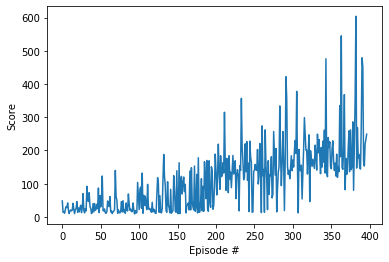

In [ ]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
  """Deep Q-Learning.
  
  Params
  ======
      n_episodes (int): maximum number of training episodes
      max_t (int): maximum number of timesteps per episode
      eps_start (float): starting value of epsilon, for epsilon-greedy action selection
      eps_end (float): minimum value of epsilon
      eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
  """
  scores = []
  scores_window = deque(maxlen = 100)
  eps = eps_start

  for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for t in range(max_t):
      action = agent.act(state, eps)
      next_state, reward, done, _ = env.step(action)
      agent.step(state, action, reward, next_state, done)
      state = next_state
      score += reward
      if done :
        break

    scores_window.append(score)
    scores.append(score)
    eps = max(eps_end, eps_decay * eps)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=200.0:
      print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
      torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
      break
  return scores


scores = dqn()



# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:

# -*- coding: utf-8 -*-
"""Segment tree for Prioritized Replay Buffer."""

import operator
from typing import Callable


class SegmentTree:
    """ Create SegmentTree.
    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py
    Attributes:
        capacity (int)
        tree (list)
        operation (function)
    """

    def __init__(self, capacity: int, operation: Callable, init_value: float):
        """Initialization.
        Args:
            capacity (int)
            operation (function)
            init_value (float)
        """
        assert (
            capacity > 0 and capacity & (capacity - 1) == 0
        ), "capacity must be positive and a power of 2."
        self.capacity = capacity
        self.tree = [init_value for _ in range(2 * capacity)]
        self.operation = operation

    def _operate_helper(
        self, start: int, end: int, node: int, node_start: int, node_end: int
    ) -> float:
        """Returns result of operation in segment."""
        if start == node_start and end == node_end:
            return self.tree[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._operate_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._operate_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self.operation(
                    self._operate_helper(start, mid, 2 * node, node_start, mid),
                    self._operate_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end),
                )

    def operate(self, start: int = 0, end: int = 0) -> float:
        """Returns result of applying `self.operation`."""
        if end <= 0:
            end += self.capacity
        end -= 1

        return self._operate_helper(start, end, 1, 0, self.capacity - 1)

    def __setitem__(self, idx: int, val: float):
        """Set value in tree."""
        idx += self.capacity
        self.tree[idx] = val

        idx //= 2
        while idx >= 1:
            self.tree[idx] = self.operation(self.tree[2 * idx], self.tree[2 * idx + 1])
            idx //= 2

    def __getitem__(self, idx: int) -> float:
        """Get real value in leaf node of tree."""
        assert 0 <= idx < self.capacity

        return self.tree[self.capacity + idx]


class SumSegmentTree(SegmentTree):
    """ Create SumSegmentTree.
    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py
    """

    def __init__(self, capacity: int):
        """Initialization.
        Args:
            capacity (int)
        """
        super(SumSegmentTree, self).__init__(
            capacity=capacity, operation=operator.add, init_value=0.0
        )

    def sum(self, start: int = 0, end: int = 0) -> float:
        """Returns arr[start] + ... + arr[end]."""
        return super(SumSegmentTree, self).operate(start, end)

    def retrieve(self, upperbound: float) -> int:
        """Find the highest index `i` about upper bound in the tree"""
        # TODO: Check assert case and fix bug
        assert 0 <= upperbound <= self.sum() + 1e-5, "upperbound: {}".format(upperbound)

        idx = 1

        while idx < self.capacity:  # while non-leaf
            left = 2 * idx
            right = left + 1
            if self.tree[left] > upperbound:
                idx = 2 * idx
            else:
                upperbound -= self.tree[left]
                idx = right
        return idx - self.capacity


class MinSegmentTree(SegmentTree):
    """ Create SegmentTree.
    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py
    """

    def __init__(self, capacity: int):
        """Initialization.
        Args:
            capacity (int)
        """
        super(MinSegmentTree, self).__init__(
            capacity=capacity, operation=min, init_value=float("inf")
        )

    def min(self, start: int = 0, end: int = 0) -> float:
        """Returns min(arr[start], ...,  arr[end])."""
        return super(MinSegmentTree, self).operate(start, end)

In [ ]:
class ReplayBuffer:
  def __init__(self, action_size, buffer_size, batch_size, seed):
    """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
    """
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size) 
    self.max_size = buffer_size 
    self.batch_size = batch_size
    self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    self.seed = random.seed(seed)


  def add(self, state, action, reward, next_state, done):
    """Add a new experience to memory."""

    e = self.experience(state, action, reward, next_state, done)
    self.memory.append(e)

  def sample(self):

    experiences = random.sample(self.memory, k=self.batch_size)
    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

    return (states, actions, reward, next_states, dones)

  def __len__(self):
    """Return the current size of internal memory."""
    return len(self.memory)

In [ ]:
import random
from collections import namedtuple, deque
import numpy as np
#from numpy.random import choice
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class PrioritizedReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, experiences_per_sampling, seed, compute_weights):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            experiences_per_sampling (int): number of experiences to sample during a sampling iteration
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.experiences_per_sampling = experiences_per_sampling

        self.alpha = 0.5
        self.alpha_decay_rate = 0.99
        self.beta = 0.5
        self.beta_growth_rate = 1.001
        self.seed = random.seed(seed)
        self.compute_weights = compute_weights
        self.experience_count = 0

        self.experience = namedtuple("Experience",
                                     field_names=["state", "action", "reward", "next_state", "done"])
        self.data = namedtuple("Data",
                               field_names=["priority", "probability", "weight", "index"])

        indexes = []
        datas = []
        for i in range(buffer_size):
            indexes.append(i)
            d = self.data(0, 0, 0, i)
            datas.append(d)

        self.memory = {key: self.experience for key in indexes}
        self.memory_data = {key: data for key, data in zip(indexes, datas)}
        self.sampled_batches = []
        self.current_batch = 0
        self.priorities_sum_alpha = 0
        self.priorities_max = 1
        self.weights_max = 1

    def update_priorities(self, tds, indices):
        for td, index in zip(tds, indices):
            N = min(self.experience_count, self.buffer_size)

            updated_priority = td[0]
            if updated_priority > self.priorities_max:
                self.priorities_max = updated_priority

            if self.compute_weights:
                updated_weight = ((N * updated_priority) ** (-self.beta)) / self.weights_max
                if updated_weight > self.weights_max:
                    self.weights_max = updated_weight
            else:
                updated_weight = 1

            old_priority = self.memory_data[index].priority
            self.priorities_sum_alpha += updated_priority ** self.alpha - old_priority ** self.alpha
            updated_probability = td[0] ** self.alpha / self.priorities_sum_alpha
            data = self.data(updated_priority, updated_probability, updated_weight, index)
            self.memory_data[index] = data

    def update_memory_sampling(self):
        """Randomly sample X batches of experiences from memory."""
        # X is the number of steps before updating memory
        self.current_batch = 0
        values = list(self.memory_data.values())
        print([data.probability for data in values][0],len(self.memory_data),"!!!!!!!")
        random_values = np.random.choice(self.memory_data, self.experiences_per_sampling,
                                       p=[data.probability for data in values])
        self.sampled_batches = [random_values[i:i + self.batch_size]
                                for i in range(0, len(random_values), self.batch_size)]

    def update_parameters(self):
        self.alpha *= self.alpha_decay_rate
        self.beta *= self.beta_growth_rate
        if self.beta > 1:
            self.beta = 1
        N = min(self.experience_count, self.buffer_size)
        self.priorities_sum_alpha = 0
        sum_prob_before = 0
        for element in self.memory_data.values():
            sum_prob_before += element.probability
            self.priorities_sum_alpha += element.priority ** self.alpha
        sum_prob_after = 0
        for element in self.memory_data.values():
            probability = element.priority ** self.alpha / self.priorities_sum_alpha
            sum_prob_after += probability
            weight = 1
            if self.compute_weights:
                weight = ((N * element.probability) ** (-self.beta)) / self.weights_max
            d = self.data(element.priority, probability, weight, element.index)
            self.memory_data[element.index] = d
        print("sum_prob before", sum_prob_before)
        print("sum_prob after : ", sum_prob_after)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.experience_count += 1
        index = self.experience_count % self.buffer_size

        if self.experience_count > self.buffer_size:
            temp = self.memory_data[index]
            self.priorities_sum_alpha -= temp.priority ** self.alpha
            if temp.priority == self.priorities_max:
                self.memory_data[index].priority = 0
                self.priorities_max = max(self.memory_data.items(), key=operator.itemgetter(1)).priority
            if self.compute_weights:
                if temp.weight == self.weights_max:
                    self.memory_data[index].weight = 0
                    self.weights_max = max(self.memory_data.items(), key=operator.itemgetter(2)).weight

        priority = self.priorities_max
        weight = self.weights_max
        self.priorities_sum_alpha += priority ** self.alpha
        probability = priority ** self.alpha / self.priorities_sum_alpha
        e = self.experience(state, action, reward, next_state, done)
        self.memory[index] = e
        d = self.data(priority, probability, weight, index)
        self.memory_data[index] = d

    def sample(self):
        print(len(self.sampled_batches),self.current_batch )
        sampled_batch = self.sampled_batches[self.current_batch]
        self.current_batch += 1
        experiences = []
        weights = []
        indices = []

        for data in sampled_batch:
            experiences.append(self.memory.get(data.index))
            weights.append(data.weight)
            indices.append(data.index)

        states = torch.from_numpy(
            np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(
            np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(
            np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(
            np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones, weights, indices)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
class QNetwork(nn.Module):
  """Actor (Policy) Model."""
  def __init__(self, state_size, action_size, seed, fc1_unit=64, fc2_unit=64):
    """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
    """
    super(QNetwork, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, fc1_unit)
    self.fc2 = nn.Linear(fc1_unit, fc2_unit)
    self.fc3 = nn.Linear(fc2_unit, action_size)

  def forward(self, state):
    """Build a network that maps state -> action values."""
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

In [ ]:
UPDATE_NN_EVERY = 1 

# prioritized experience replay
UPDATE_MEM_EVERY = 20  # how often to update the priorities
UPDATE_MEM_PAR_EVERY = 1000  # how often to update the hyperparameters
EXPERIENCES_PER_SAMPLING = int(math.ceil(BATCH_SIZE * UPDATE_MEM_EVERY / UPDATE_NN_EVERY))

In [ ]:
class Agent():
  """Interacts with and learns from the environment."""

  def __init__(self, state_size, action_size, seed):
    """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
    """
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    self.memory = PrioritizedReplayBuffer(
            self.action_size, BUFFER_SIZE, BATCH_SIZE, BATCH_SIZE, seed, False)
    # Initialize time step (for updating every UPDATE_NN_EVERY steps)
    self.t_step_nn = 0
    # Initialize time step (for updating every UPDATE_MEM_PAR_EVERY steps)
    self.t_step_mem_par = 0
    # Initialize time step (for updating every UPDATE_MEM_EVERY steps)
    self.t_step_mem = 0

    #Q-Networks
    self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
    self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    # Save experience in replay memory
    self.memory.add(state, action, reward, next_state, done)

    # Learn every UPDATE_NN_EVERY time steps.
    self.t_step_nn = (self.t_step_nn + 1) % UPDATE_NN_EVERY
    self.t_step_mem = (self.t_step_mem + 1) % UPDATE_MEM_EVERY
    self.t_step_mem_par = (self.t_step_mem_par + 1) % UPDATE_MEM_PAR_EVERY

    if self.t_step_nn == 0:
      # If enough samples are available in memory, get random subset and learn
      if self.memory.experience_count > EXPERIENCES_PER_SAMPLING:
        sampling = self.memory.sample()
        self.learn(sampling, GAMMA)

  def act(self, state, eps = 0):
    """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
      action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    if random.random() > eps:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))


  def learn(self, experiences, gamma):
    states, actions, reward, next_states, dones = experiences
    # Get max predicted Q values (for next states) from target model
    Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
    # Compute Q targets for current states
    Q_targets = reward + (gamma * Q_targets_next * (1 - dones))
    # Get expected Q values from local model
    Q_expected = self.qnetwork_local(states).gather(1, actions)
    #Compute loss 
    loss = F.mse_loss(Q_expected, Q_targets)
    #Minimize loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # ------------------- update target network ------------------- #
    self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)     
  
  def soft_update(self, local_model, target_model, tau):
    """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
agent = Agent(state_size=4, action_size=2, seed=0)

state = env.reset()
for j in range(200):
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

In [ ]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
  """Deep Q-Learning.
  
  Params
  ======
      n_episodes (int): maximum number of training episodes
      max_t (int): maximum number of timesteps per episode
      eps_start (float): starting value of epsilon, for epsilon-greedy action selection
      eps_end (float): minimum value of epsilon
      eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
  """
  scores = []
  scores_window = deque(maxlen = 100)
  eps = eps_start

  for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for t in range(max_t):
      action = agent.act(state, eps)
      next_state, reward, done, _ = env.step(action)
      agent.step(state, action, reward, next_state, done)
      state = next_state
      score += reward
      if done :
        break

    scores_window.append(score)
    scores.append(score)
    eps = max(eps_end, eps_decay * eps)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=200.0:
      print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
      torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
      break
  return scores


scores = dqn()



# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 57	Average Score: 22.350 0


IndexError: ignored